### External modules used in this documentation

In this short code section we upload all the needed modules for this documentation.

In [99]:
import pandas as pd
from json import load
from matplotlib import *

___

# Software documentation

1. [Introduction](#introduction) 
2. [Data description](#data_description)
3. [Software organization](#software_organization)
    - [requirements.txt](#requirements.txt)
    - [const.py](#const.py)
    - [URIs.py](#URIs.py)
    - [data_model.py](#data_model.py)
    - [common_utils.py](#common_utils.py)
    - [main.py](#main.py)
    - [data_processors.py](#data_processors.py)
    - [relational_processor.py](#relational_processor.py)
    - [triplestore_processor.py](#triplestore_processor.py)
    - [query_processors.py](#query_processors.py)
    - [queries.py](#queries.py)
    
4. [Functioning](#functioning)
5. [Descriptive Statics](#descriptive_statistics)

<div id=introduction> </div>

# 1. Introduction

### Project goal
Our goal is to build a software that enables to populate two kinds of databases, a relational and a graph database, and to query these databases simultaneously.  
In this project, we will deal with *structured data* coming from CSV and JSON files. For processing the data in Python we will use [***pandas***](https://pandas.pydata.org/), a Python package providing fast, flexible, and expressive data structures designed to make working with “relational” or “labelled” data both easy and intuitive.

After shortly analysing the provided data and their characteristics, we developed the processors that will extract the data from the provided CSVs and JSONs, to populate our structured collection of data. We will then upload the records created into our databases, as well as provide the possibility to query these databases simultaneously and return specific Python objects.

### Design and syntax choices

#### Type annotation
Since a main characteristic of the Python language is the consistency of its object model, we tried to explicit what kind of object a function is dealing with in input and output. Each object has an associated type (e.g., integer, string, list, etc.) and internal data. We choose, for better readability, to make the Data Types of the input parameters (arguments) and the output of the function explicit by the use of type annotation.
E.g.  

    def set_df(self, _df: DataFrame) -> None:

In the example above, `set_df` will take a DataFrame as input and will return anything, so None. Note, though, that this is syntactic sugar only, Python will not raise an error if the Data Type of the arguments specified in the annotation is not respected.
    
#### Try/except statement
We made use of the `try/except` statement in the code to handle errors. [The `try/except` statement works as follows:](https://docs.python.org/3/tutorial/errors.html)

- First, the try clause (the statement(s) between the try and except keywords) is executed.
- If no exception occurs, the except clause is skipped and execution of the try statement is finished.
- If an exception occurs during the execution of the try clause, the rest of the clause is skipped. Then, if its type matches the exception named after the except keyword, the except clause is executed, and then execution continues after the try/except block.

It is also possible to catch the specific Python error in the except statement with the build-in class `Exception` and print it in the terminal.

### *set* and *get*
We tried to use as much as possible *set* and *get* methods to add a security layer when we write or read class properties. So we can check the value that is going to be written in a property. For example `set_graph` method of the `GraphDataProcessor` class writes the RDF graph inside the property just if it is not empty, otherwise, an error is printed in the console.

#### Terminal messages
To be able to know at which step our program is during the execution, we made use of terminal messages. We divided these messages into three main categories. `INFO` messages updated the user about the step currently starting or just finished. `ERR` messages are alerts that report where the app failed its execution and it stops while `WARN` was used to indicate when a query returned zero results.

#### Case formats
We tried to use different case formats to indicate the different parts of our code. More in detail we used:
- Pascal Case (PascalCase) for naming classes (e.g. `IdentifiableEntity`, `Person`, etc…)
- Camel case (camelCase) for the class methods (e.g. `getIds`, `getGivenName`, etc…)
- Snake case (snake_case), with an additional initial "_" for the functions arguments (e.g. `_id_list`, `_url`, etc…). Snake case was also used for naming some generic functions like those in the `common_utils.py` file (e.g. `csv_to_df`, `json_to_df`, etc…) and for naming constants (e.g. `BASE_URL`, `DB_PATH`, etc…)

#### Constants names
We used a capital letter syntax to easily read constants.
E.g. We will write the datasets paths as:

    GRAPH_CSV_FILE; GRAPH_JSON_FILE; RELATIONAL_CSV_FILE; RELATIONAL_JSON_FILE

###  Let's start
We started by analysing the data that has been provided to understand the different cases we had to handle and their characteristics.  We have then created two data processors that we will use to extract data from the datasets provided and we will process them for the relational database and the graph one.

---

<a id='data_description'></a>

# 2. Data description

We started by analysing the exemplar JSON and CSV files that we have been provided with to test the software.
The CSV files, both the *relational_publications.csv* and the *graph_publications.csv*, are composed of the following columns:

    id, title, type, publication_year, issue, volume, chapter, publication_venue, venue_type, publisher, event

In [100]:
relational_csv = read_csv("../data/relational_publications.csv")
for columns in relational_csv:
    print(columns)

id
title
type
publication_year
issue
volume
chapter
publication_venue
venue_type
publisher
event


In [101]:
graph_csv = read_csv("../data/graph_publications.csv")
for columns in graph_csv:
    print(columns)

id
title
type
publication_year
issue
volume
chapter
publication_venue
venue_type
publisher
event


Each row defines a publication entity.
As defined in the given UML, we will have three types of publications: journal articles, book chapters and proceedings papers.
Journal articles can also have issue and volume specified, while book chapters must have a chapter number.

![datamodel](img/datamodel.png)

In the JSON files, *relational_other_data.json* and *relational_other_data.json*, we will find additional pieces of information about the publications and their related classes. In particular, the JSON files are structured in 4 main keys:

    authors, venues_id, references, publishers

The first three sections contain additional information about authors, venues and citations of other publications through the publications' unique identifiers (DOI) used as sub-key inside each of these three macros "dictionaries". The fourth key gives further information about the publishers that can be connected to the information of our CSV through the mediation of their crossref identifier, which is used as a key inside the JSON.

The files have been analysed both manually and using Python in order to better understand both quantitative and the qualitative characteristics of the data.

In [102]:
relational_json = open("../data/relational_other_data.json", 'r', encoding='utf-8')

relational_json_df = load(relational_json)
for columns in relational_json_df:
    print(columns)

authors
venues_id
references
publishers


In [103]:
graph_json = open("../data/graph_other_data.json", 'r', encoding='utf-8')

graph_json_df = load(graph_json)
for columns in graph_json_df:
    print(columns)

authors
venues_id
references
publishers


### Quantitative characteristics of datasets.

#### CSV

We can inspect how the datasets are composed through the *info* pandas method after reading into Python the CSVs. In addition, we can use the *head* method to look at the first 5 rows of our CSV tables.

In [104]:
relational_publications = read_csv("../data/relational_publications.csv")
relational_publications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 500 non-null    object 
 1   title              500 non-null    object 
 2   type               500 non-null    object 
 3   publication_year   500 non-null    int64  
 4   issue              347 non-null    object 
 5   volume             443 non-null    object 
 6   chapter            22 non-null     float64
 7   publication_venue  498 non-null    object 
 8   venue_type         498 non-null    object 
 9   publisher          498 non-null    object 
 10  event              0 non-null      float64
dtypes: float64(2), int64(1), object(8)
memory usage: 43.1+ KB


In [105]:
relational_publications.head()

,id,title,type,publication_year,issue,volume,chapter,publication_venue,venue_type,publisher,event
0,doi:10.1162/qss_a_00023,"Opencitations, An Infrastructure Organization ...",journal-article,2020,1,1,NaN,Quantitative Science Studies,journal,crossref:281,NaN
1,doi:10.1007/s11192-019-03217-6,"Software Review: Coci, The Opencitations Index...",journal-article,2019,2,121,NaN,Scientometrics,journal,crossref:297,NaN
2,doi:10.1007/s11192-019-03311-9,Nine Million Book Items And Eleven Million Cit...,journal-article,2019,2,122,NaN,Scientometrics,journal,crossref:297,NaN
3,doi:10.1038/sdata.2016.18,The Fair Guiding Principles For Scientific Dat...,journal-article,2016,1,3,NaN,Scientific Data,journal,crossref:297,NaN
4,doi:10.1371/journal.pbio.3000385,The Nih Open Citation Collection: A Public Acc...,journal-article,2019,10,17,NaN,Plos Biology,journal,crossref:340,NaN


In [106]:
graph_publications = read_csv("../data/graph_publications.csv")
graph_publications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 500 non-null    object 
 1   title              500 non-null    object 
 2   type               500 non-null    object 
 3   publication_year   500 non-null    int64  
 4   issue              303 non-null    object 
 5   volume             391 non-null    object 
 6   chapter            93 non-null     float64
 7   publication_venue  486 non-null    object 
 8   venue_type         486 non-null    object 
 9   publisher          486 non-null    object 
 10  event              0 non-null      float64
dtypes: float64(2), int64(1), object(8)
memory usage: 43.1+ KB


In [107]:
graph_publications.head()

,id,title,type,publication_year,issue,volume,chapter,publication_venue,venue_type,publisher,event
0,doi:10.1016/j.websem.2021.100655,Crossing The Chasm Between Ontology Engineerin...,journal-article,2021,NaN,70,NaN,Journal Of Web Semantics,journal,crossref:78,NaN
1,doi:10.1007/s10115-017-1100-y,Core Techniques Of Question Answering Systems ...,journal-article,2017,3,55,NaN,Knowledge And Information Systems,journal,crossref:297,NaN
2,doi:10.1016/j.websem.2014.03.003,Api-Centric Linked Data Integration: The Open ...,journal-article,2014,NaN,29,NaN,Journal Of Web Semantics,journal,crossref:78,NaN
3,doi:10.1093/nar/gkz997,The Monarch Initiative In 2019: An Integrative...,journal-article,2019,D1,48,NaN,Nucleic Acids Research,journal,crossref:286,NaN
4,doi:10.3390/publications7030050,Dras-Tic Linked Data: Evenly Distributing The ...,journal-article,2019,3,7,NaN,Publications,journal,crossref:1968,NaN


As we see in this first exploration of the two CSV provided, we already see some quantitative differences between the two datasets. This led to the conclusion that the two databases we will create could have different information about different publications.

Lets merge the two datasets into one.

In [108]:
# Concatenate both DataFrame(s).
publications_df = pd.concat(
                            [graph_publications, relational_publications],
                            ignore_index=True 
                       ).reset_index(drop=True)
publications_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1000 non-null   object 
 1   title              1000 non-null   object 
 2   type               1000 non-null   object 
 3   publication_year   1000 non-null   int64  
 4   issue              650 non-null    object 
 5   volume             834 non-null    object 
 6   chapter            115 non-null    float64
 7   publication_venue  984 non-null    object 
 8   venue_type         984 non-null    object 
 9   publisher          984 non-null    object 
 10  event              0 non-null      float64
dtypes: float64(2), int64(1), object(8)
memory usage: 86.1+ KB


We can also ask for more information about the values of each column. For retrieving this information, we use the method *describe*. Using the optional input named parameter *include* set to "all" we can obtain an overall view of the values inside the CSV.

In [109]:
publications_df.describe(include="all")

,id,title,type,publication_year,issue,volume,chapter,publication_venue,venue_type,publisher,event
count,1000,1000,1000,1000.000000,650,834,115.000000,984,984,984,0.0
unique,994,991,2,NaN,47,185,NaN,556,2,49,NaN
top,doi:10.3233/ds-190016,Question Answering On Scholarly Knowledge Graphs,journal-article,NaN,1,11,NaN,Scientometrics,journal,crossref:297,NaN
freq,2,2,885,NaN,132,51,NaN,51,885,318,NaN
mean,NaN,NaN,NaN,2019.345000,NaN,NaN,0.860870,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,1.662149,NaN,NaN,0.347597,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,2011.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,2018.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,2020.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,2021.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN


We can see that:
- there are two publications with the same title: "Question Answering On Scholarly Knowledge Graphs";
- the oldest publication was published in 2011 while the newest in 2022.

In [110]:
graph_publications.query('title == "Question Answering On Scholarly Knowledge Graphs"')

,id,title,type,publication_year,issue,volume,chapter,publication_venue,venue_type,publisher,event
19,doi:10.1007/978-3-030-54956-5_2,Question Answering On Scholarly Knowledge Graphs,book-chapter,2020,NaN,NaN,1.0,Digital Libraries For Open Knowledge - Lecture...,book,crossref:297,NaN


In [111]:
relational_publications.query('title == "Question Answering On Scholarly Knowledge Graphs"')

,id,title,type,publication_year,issue,volume,chapter,publication_venue,venue_type,publisher,event
10,doi:10.1007/978-3-030-54956-5_2,Question Answering On Scholarly Knowledge Graphs,book-chapter,2020,NaN,NaN,1.0,Digital Libraries For Open Knowledge - Lecture...,book,crossref:297,NaN


We noticed that two exact publications are in both CSV. We should keep this in mind when we will return results from the queries. We could use the [`drop_duplicates` method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html) from pandas when creating the result DataFrame.

#### JSON

In [112]:
relational_other_data = read_json("../data/relational_other_data.json")
relational_other_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 540 entries, doi:10.1162/qss_a_00023 to crossref:301
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   authors     508 non-null    object
 1   venues_id   498 non-null    object
 2   references  500 non-null    object
 3   publishers  32 non-null     object
dtypes: object(4)
memory usage: 21.1+ KB


In [113]:
relational_other_data.describe(include="all")

,authors,venues_id,references,publishers
count,508,498,500,32
unique,486,297,99,32
top,"[{'family': 'Leydesdorff', 'given': 'Loet', 'o...","[issn:0138-9130, issn:1588-2861]",[],"{'id': 'crossref:6228', 'name': 'Codon Publica..."
freq,4,50,366,1


In [114]:
graph_other_data = read_json("../data/graph_other_data.json")
graph_other_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 563 entries, doi:10.1016/j.websem.2021.100655 to crossref:4443
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   authors     526 non-null    object
 1   venues_id   486 non-null    object
 2   references  500 non-null    object
 3   publishers  37 non-null     object
dtypes: object(4)
memory usage: 22.0+ KB


In [115]:
graph_other_data.describe(include="all")

,authors,venues_id,references,publishers
count,526,486,500,37
unique,492,309,101,37
top,"[{'family': 'Pal', 'given': 'Kamalendu', 'orci...",[issn:2076-3417],[],"{'id': 'crossref:735', 'name': 'Thomas Telford..."
freq,4,15,331,1


As for the CSVs, also for the data provided inside the JSONs, we found some quantitative differences.

Since the final outputs of the software must be Python objects that reflect the data stored in both databases, we will have to check for common entries and different ones. We kept this in mind while creating the generic query processor.

---

<a id='software_organization'></a>

# 3. Software organization

We try to organize the software to be scalable and accessible.
It is scalable since we tried to keep the code as general-purpose as possible. The idea is to have a basic structure that can be adapted to different datasets or future implementation of different kinds of databases.
It is accessible since we designed an **entry point, `main.py`,** for easy access to the software. This feature was also important in the testing and debugging phases.

Let's take a look at all the files contained in the program.

<div id="requirements.txt"></div>

## requirements.txt

Python requirements files are a great way to keep track of the Python modules. It is a simple text file that saves a list of the modules and packages required by your project. By creating a Python requirements.txt file, you save yourself the hassle of having to track down and install all of the required modules manually.

It makes it easy to share your project with others. They install the same Python modules you have listed in your requirements file and run your project without any problems.

In case you ever need to update or add a Python module to your project, you simply update the requirements file rather than having to search through all of your code for every reference to the old module.

<div id="const.py"></div>

## const.py

In this file we stored all the constants we will need in our project. This feature allows us to easily change the value of elements widely used in the execution. For example, you will find the data source's local path, the base URL of our RDF resources we will create, the path where the relational database file will be stored, and so on.

Regarding the triplestore database, we also decide to store here the queries we will use in the `TriplestoreQueryProcessor`, this allows us to have a more clear code in the query processor.

<div id="URIs.py"></div>

## URIs.py

The [*Resource Description Framework* (RDF)](https://www.w3.org/RDF/) allows users to describe both Web documents and concepts from the real world—people, organisations, topics, things—in a computer-processable way. Publishing such descriptions on the Web creates the Semantic Web. [URIs (*Uniform Resource Identifiers*)](https://www.w3.org/Addressing/URL/uri-spec.html) are very important, providing both the core of the framework itself and the link between RDF and the Web.

To have them all in one place we created a dedicated file. All classes of resources and properties that relate to them, defined by the UML provided, will be presented here.

<div id="data_model.py"></div>

## data_model.py

The structure presented in UML is translated in this file.

![datamodel](img/datamodel.png)

We define all the Python classes and relative sub-classes.
This process is important to return Python objects from the queries.

<div id="common_utils.py"></div>

## common_utils.py

Here you can find the general functions that we used in the program. They address specific tasks we need to perform during the execution. You can find in this file custom functions like: `csv_to_df`, `json_to_df` or `blazegraph_instance_is_active` that check through an HTTP request if the Blazegraph service is active or not.

<div id="main.py"></div>

## main.py

This is the entry point of our program, we launch all the processes we need to obtain our outputs, all wrapped in an `app` function.

A key aspect of devoloping a complex program like this one was to allow the possibility to run debugs.
Since we used Visual Studio Core as editor, we took advantage of one of the key features of this editor, its great debugging support. VS Code's built-in debugger helps accelerate the edit, compile, and debug loop.
To be able to do so we set up the `launch.json` file(contained in the `.vscode` folder) as reported in [this guide by VS Code](https://code.visualstudio.com/docs/editor/debugging).



<div id="data_processors.py"></div>

## data_processors.py

In this file, we process all the data provided and we build the [pandas DataFrames](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) we will need to populate our databases.

We created a custom class `DataProcessor` that will take as attributes all the DataFrames we will create. As made in other cases, when we need to write or read attributes of a class, we used the respective *set* and *get* methods for each attribute.

You can also find the custom `DataProcessor`'s sub-class we created, `GraphDataProcessor`, where we compose all the triplets of our graph database. As properties of this class, we set all the dictionaries we used in the process to create the relation between the different entities we describe. 

In the original design of the program, we had imagined performing in this file also the creation of the tables for the relational database. In the final design presented here, we instead split the creation of the tables for the relational database in another file that we will see later.

<div id="relational_processor.py"></div>

## relational_processor.py

The upload data function in relational data processors are divided into 2 parts. when we upload csv data we create all tables required for both csv and json. for csv data we populate these: Book, BookChapter, Journal, JournalArticles, PublicationID. Proceeeding and ProceedingPaper are empty according to our data.

We also create these empty tables to make it ready to use for json data in next step:
Author, Cites, Organization, OrgID, Person, PersonID, and VenueID.

With json data, references are linked to publications. Moreover, venue ids is linked to venues. Additionaly, authors and organizations are linked to publications and venues.

For creating tables for each publication type we merge citations, authors and venues.

In order to link publications to authors, we create author table with dois and personID table.

<div id="triplestore_processor.py"></div>

## triplestore_processor.py

After the creation of the triplets in the `data_processor.py`, we upload them to our online service, Blazegraph, to be stored and to have a queryable endpoint.

The base class `TriplestoreProcessor` stores in the variable `endpointUrl` the URL of the SPARQL endpoint, initially set as an empty string, that will be updated with the method `setEndpointUrl`

The sub-class `TriplestoreDataProcessor`, with its method `uploadData`, enables to upload of the collection of data specified in the input file path into the database. We check if the file in input is a CSV or JSON and we launch the methods for the creation of the different DataFrames, already created in the `GraphDataProcessor`. Before this step, we check if the data are already been uploaded in a precedent execution.

<div id="query_processors.py"></div>

## query_processors.py

Two main classes will be contained in this file: `RelationalQueryProcessor` and `TriplestoreQueryProcessor`. Both classes will have as methods the queries required in the project guidelines. As designed in the "UML of additional classes", these two classes will be sub-classes of the respective processor classes (`RelationalProcessor` and `TriplestoreProcessor`) and also both sub-classes of a generic `QueryProcessor`.

In this same file, we clean the DataFrames returning from each query processor and we combine the two in one DataFrame with the [pandas concat method.](https://pandas.pydata.org/docs/reference/api/pandas.concat.html?highlight=concat#pandas.concat)

<div id="queries.py"></div>

## query.py

We created this custom file to manage the execution of all the queries. From the `main.py` we launch the execution of the functions here contained. All the functions here contained will take as input the list of processors we have in our project (this feature allows us to add in future also another data processor if needed, like a NoSQL processor for example), after the execution of the generic query, we process the result and translate them into Python object defined in the `data_model.py`. At least we write a *txt* file for each query, these files will be stored in the `queries-results` folder.

---

<div id="functioning"></div>

# 4.Functioning

The functioning of the program can be resumed in the following image:

![workflow](img/workflow.png)

## We start from *main.py*

The execution of our program starts from the entry point, set in the `launch.json` file, the `main.py`. The app starts running and the first message appears in the console to confirm that. 

The `app` function contains the whole program. As already said, this design helps create a more clear sequence of steps that the program needs to execute to achieve our final goal.

Since we will use a few external libraries to handle specific tasks, we insert the execution of `app` in a *try/except* statement. We do that to be able to understand if and when an error is produced during the execution, above all if the error occurs in a part of the code out of our program, an external library for example. 

As the first thing, we see a flag `data_has_been_uploaded` set by default at *False*. We will need that further on to check if the data have been correctly updated on Blazegraph.

As already mentioned Blazegraph is the web service we used to upload our graph database.
The function `blazegraph_instance_is_active()` performs an HTTP request, using a method of the external library [*request*](https://pypi.org/project/requests/), and checks if Blazegraph is already connected, otherwise we start the connection with `start_blazegraph_server()`. Once the connection is accomplished, we check if the graph database was already populated by a previous execution of the program with `blazegraph_instance_is_empty()`. A test query has been set up to check if any triples are inside the Blazegraph local endpoint (http://127.0.0.1:9999/blazegraph/sparql).

## Let's process our datasets

### Triplestore data processor
If the Blazegraph service is correctly started and the Blazegraph instance results empty, we can run our data processors.

We start with the `TriplestoreDataProcessor()`. Instantiating the class we now have access to 
its methods. The endpoint is set with `setEndpointUrl()`, a method inherited from the super-class `TriplestoreProcessor()`. 
To elaborate on all the DataFrames we will need, we created a custom class `GraphDataProcessor`. This class will populate the property *processor* of `TriplestoreDataProcessor` class with all those DataFrames.

The method `uploadData` will check into the datasets provided to which of them contains the word "graph" in the name. If the file names are valid, we check if they are CSV or JSON. From our initial analysis of the datasets provided, we know that the CSV files contain information about the Publications, while the JSON files contain information about Authors, Publishers, References and Venues.
The *processor* previously initialised allows us to use the method `publicationsDfBuilder` of `DataProcessor`class, so we can use it to write the new DataFrame of the Publications created from the CSV file as a property of the `DataProcessor` class. As already said this latter class has as properties all the DataFrames we will need to process the data.
After this, we run the DataFrame builder methods (`authorsDfBuilder`, `publishersDfBuilder`, `referncesDfBuilder` and `venuesDfBuilder`) on the JSON file.

### Creation of RDF triples
An RDF triple contains three components:
- the subject, which is an RDF URI reference or a blank node
- the predicate, which is an RDF URI reference
- the object, which is an RDF URI reference, a literal or a blank node
An RDF triple is conventionally written in the order subject, predicate and object. The predicate is also known as the property of the triple.

To work with RDF in Python we used the external library [RDFLib](https://rdflib.readthedocs.io/en/stable/).

We now have all the DataFrames from which we will create our triplets. So, after all the DataFrames have been successfully built and have been written as property of `DataProcessor` class, we can launch the `graphBuilder` method of `GraphDataProcessor`. Here the methods that actually make up the triplets are launched. So `do_organization_triples` will create all the Organizations entities, `do_venue_triples` will create all the Venues entities, `do_person_triplets` will be used to form the triplets relative to the Authors and `do_publication_triples` will be used to create all the triplets of all the Publications entities.

While creating the triplets we describe the entities we are creating. They all will have as base URL "https://allorapy.github.io/res/" plus the name of the entity (e.g. "publication-0"). The final URI of the resource will be then composed (e.g. "https://allorapy.github.io/res/publication-0") and it will be the subject of our triplets. As a predicate, we will assign the properties defined in the `URIs.py` file, where we will use different ontologies to describe our resources. As the object of the triplet, we will associate, depending on the design of the resource, a literal or another entity.

An RDF graph is a set of RDF triples. The set of nodes of an RDF graph is the set of subjects and objects of triples in the graph. All the triples created are added to our graph (*"rdf_graph"*) through the `add` method of the RDFLib external library.

### Graph deploying

The deployment on the web endpoint of our graph is handled by the method `triplestoreDeploy` of our `GraphDataProcessor` class. We initialize a `SPARQLUpdateStore` as defined in the [RDFLib sparqlstore extension documentation](https://github.com/RDFLib/rdflib-sparqlstore/blob/master/README.md). The RDFLib method `open` opens the connection with the SPARQL endpoint instance.

Each triplet in our graph will be added to the online database. When we are done we close the connection with the `close` method.

Our flag `data_has_been_uploaded` will be set to *True* if the operation is executed without errors.

#### *Problems

We encountered a bug during the deployment of the graph. We saw that the UTF-8 encoding is not respected. So, while the data are correctly read from the CSV or JSON, they are changed when uploaded in Blazegraph.

## Query the SPARQL endpoint

Now we can perform our queries.

We instantiate both the query processors, `TriplestoreQueryProcessor` and `RelationalQueryProcessor`.
The instances of these two classes will be inserted into a list of processors.
We then create a `GenericQueryProcessor` object and we add the previously created list to it through the `addQueryProcessor` method. This method will return a *boolean* value after the add.
If all processors are successfully added, *True* is returned. In case we would have a third database, the `GenericQueryProcessor` object could contain also it without problem since the list of processors is passed as input to `addQueryProcessor` and then written in the property of the class.

The following query methods are contained in the `GenericQueryProcessor` object and not in the single processors because the queries are the same for all the processors but just written in different languages (SQL for relational and SPARQL for triplestore).
Each query is called just one time but performs different actions depending on the processors in the list.

The SQL and the SPARQL queries return a DataFrame with the answer. Since the different structures of the two databases, operations of cleaning and matching of the result DataFrames are performed. We can now combine these DataFrames in one, having the same columns.

Now we can create the objects compliant with the data model provided and we append them to a list.
We can now return Python objects from the queries.

Messages in the console will be printed to confirm the execution of the queries and text files (*txt*) with the results will be written in the *queries-results* folder.

## Relational Query Processor

In the relational query processor class, we have different modules and we take as input the relational processor.
The structure of every function (i.e. module) is really similar.
First of all, we made the connection to the SQL database, where we have previously uploaded our data.
Then we have 3 main parts: SELECT, FROM, WHERE. With SELECT we are going to decide the columns that we are interested in from a specific table and those we want to show in the output. The table we are considering is the one named in FROM part. In the WHERE section we filter our table for values (as rows) that should be returned as output.
If we have stored our data in different tables of the database, to obtain a complete output, we have to JOIN those. In our modules it was done with a LEFT JOIN, to be sure of keeping all the data present in the table selected in the FROM section, although it has no correspondence in tables that are joined. A NAN value fills the white slots here.
It is important to keep in mind that in every SELECT of every UNION part, we must have the same number of columns. Output of every part is going to be added at the bottom of the previous query.
The outputs of queries of the relational query processor are dataframes as per guidelines. Those outputs are then shared with other parts of the code as the generic part.

#### Let's explain a module as an example:
getPublicationsByAuthorName: It returns a data frame with all the publications (i.e. the rows) that have been authored by the people having their name matching (in lowercase), even partially, with the name specified as input (e.g. "doe").

Based on tables created on the database we should go from a string (the name of the author) or from a partial string to the publications that are authored by people that are named with this string.
First of all, we know that we want all the publications under this condition, so since we have publications in 3 different tables (JournalArticles, BookChapter, ProceedingPaper) we should go to query all of them. We are going to do 3 different queries and then we'll join them through the UNION.
So we set our first table to be queried in the FROM (JournalArticle), and then we LEFT JOIN tables (bridge tables and tables that contain data we want to return). Author is here a table used as a bridge because we need it only to connect JournalArticle to Person. We linked the two tables through the common column AuthorID (named author in the JournalArticle table). We decided to add also the PubID table to be able to return the publication id as an identifier.
We can now filter our 'virtual table' using the WHERE. We could have capital letters, so we have to clean a little data before going ahead. We lower all the letters of the given name and of the family name. We search with the WHERE instruction the strings that are equal (or partially equal adding % before) to the authorPartialName given by input.
We have now a bigger table than we need (and want), so we are going to SELECT only the columns whose we are really interested in, keeping in mind that, if we want to return a column that won't be present in the tables we are going to create for BookChapter and ProceedingPaper, we will have to set the column as NA in the SELECT of the table where it is absent.
We repeat the process for BookChapter and ProceedingPaper.

<ol style="font-size: 1.2em; line-height: 1.5em;">
<li><code>getPublicationPublishedInYear()</code>: it takes in input a year and returns a dataframe with all publications published in the input date</li>
<li><code>getPublicationisByAuthorId()</code>: it takes in input a person's identifier and returns in a dataframe all the publications that are been authored by the author with the id given as input</li>
<li><code>getMostPublication()</code>: it returns publications that have the most number of citations in a dataframe</li>
<li><code>getMostCitedVenue()</code>: it returns publications' venue that have the most number of citations in a dataframe</li>
<li><code>getVenuesByPublisherId()</code>: it takes in input an identifier of an organization and returns all the publications published by this organization in a dataframe</li>
<li><code>getPublicationInVenue()</code>: it takes a venue id and returns all the publications having those venue in a dataframe</li>
<li><code>getJouarnalArticlesInIssue()</code>: it takes in input issue, volume and journal id and returns the JournalArticles that match with those values in a dataframe</li>
<li><code>getJouarnalArticlesInVolume()</code>: it takes in input volume and journal id and returns the JournalArticles that match with those values in a dataframe</li>
<li><code>getJouarnalArticlesInJournal()</code>: it takes in input journal id and returns the JournalArticles that match with those values in a dataframe</li>
<li><code>getProceedingsByEvent()</code>: it takes in input a string and returns a dataframe with all the proceedings, whose event match even partially with the string</li>
<li><code>getPublicationAuthors()</code>: it takes in input a publication id and returns a dataframe with all the authors of the publication</li>
<li><code>getDistinctPublisherOfPublications()</code>: it takes in input a list with publication id and returns a dataframe with all the publishers that have published the venue of the publication id as input</li>
</ol>


<div id='descriptive_statistics'></div>

# 5. Descriptive Statistics



As we saw in the description of the data, just two kinds of publications type seem to be present. To confirm that we can use the method [`unique`](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html) by pandas.

In [116]:
print("-- Categories describing types of publications")
publications_df["type"].unique()

-- Categories describing types of publications


array(['journal-article', 'book-chapter'], dtype=object)

Pandas make available also methods to [represent data in graphs](https://pandas.pydata.org/docs/user_guide/visualization.html#visualization). We tried, for example, to see how many times these different types of publications are present in our original datasets. To do that, we first have to retrieve such a number for each type using the Series method [`value_counts`](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html), shown as follows:


In [117]:
type_count = publications_df["type"].value_counts()
type_count

journal-article    885
book-chapter       115
Name: type, dtype: int64

The method `value_counts` applied to a series of strings returns the number of times each string appears in the series, where the unique strings of the series become the index of the new series. We plotted it as a bar chart, where the index labels are the categories shown on the x-axis, while the number of times each string is represented in the original series is the value highlighted on the y-axis. This diagram is plotted using the method [`plot`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html), specifying the optional input named parameter kind set to "bar", as shown as follows:

<AxesSubplot:>

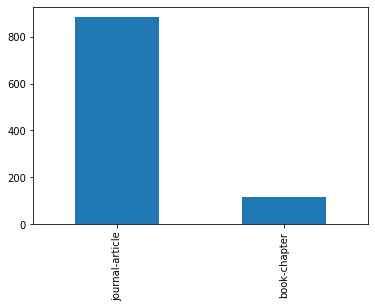

In [118]:
type_count.plot(kind="bar")

We can use a similar approach to understand, for instance, what are the top ten venues considering all the publications in the dataset. In this case, we use again the method `value_counts` and then we select the first 10 rows, as shown as follows:

In [119]:
best_venues = publications_df["publication_venue"].value_counts()[:10]
best_venues

Scientometrics                                                       51
Sustainability                                                       33
Applied Sciences                                                     18
International Journal Of Environmental Research And Public Health    15
Journal Of Biomedical Semantics                                      12
Nucleic Acids Research                                               12
Energies                                                             11
Journal Of Cleaner Production                                        10
Plos One                                                              9
Journal Of Informetrics                                               9
Name: publication_venue, dtype: int64

We plot it as a horizontal bar chart using the same command shown in the previous example, but setting the parameter `kind` to "barh":

<AxesSubplot:>

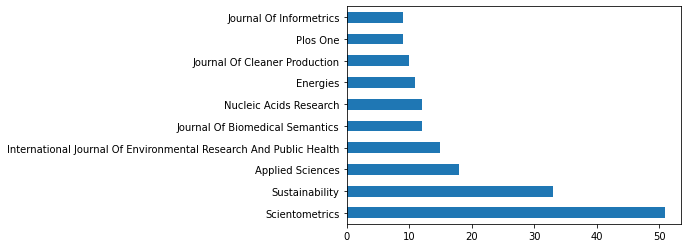

In [120]:
best_venues.plot(kind="barh")

Other statistics can be calculated using the data in the columns of the data frame. For instance, another important statistic for numeric values is the median.
We used it to see the median of the year of publication of our publications.

In [121]:
print("-- Median value of the publication years in the data")
print(publications_df["publication_year"].median())

-- Median value of the publication years in the data
2020.0


We could be interested in understanding how many publications have been published each year. To retrieve this information, we can use again the method `value_counts`, but this time applied to the column publication year, as shown as follows:

In [122]:
publications_per_year = publications_df["publication_year"].value_counts()
publications_per_year

2021    333
2019    212
2020    166
2018    162
2017     60
2016     34
2014     14
2015     10
2022      7
2011      1
2013      1
Name: publication_year, dtype: int64

As you can see, the series contains the number of publications year by year, sorted in descending order, from the year with the most publications to that with fewer publications. To draw all these data in the correct temporal order, we need first to sort them in ascending order using the index labels (i.e. the years of publication). For doing so, we can use the Series method [`sort_index`](https://pandas.pydata.org/docs/reference/api/pandas.Series.sort_index.html) to generate a new series ordered as mentioned:

In [123]:
publications_per_year_sorted = publications_per_year.sort_index()
publications_per_year_sorted

2011      1
2013      1
2014     14
2015     10
2016     34
2017     60
2018    162
2019    212
2020    166
2021    333
2022      7
Name: publication_year, dtype: int64

Then, finally, we can plot this new series using a simple line diagram (the default for the plot method) as shown as follows:

<AxesSubplot:>

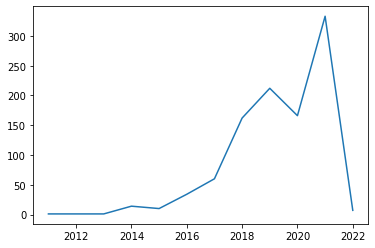

In [124]:
publications_per_year_sorted.plot()